In [1]:
import fastbook
fastbook.setup_book()

In [2]:
#| include: false
from fastbook import *
from fastai.vision.widgets import *

Retrieve files of our subject from bing image search. The images we search for are downloaded locally.

In [23]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xyz')

In [6]:
results = search_images_bing(key, 'trilobite')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
fossil_types = 'trilobite', 'crinoid', 'bivalve'
path = Path('critters')

In [40]:
for o in fossil_types:
    dest = (path/o)
    if not dest.exists():
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} fossil')
        download_images(dest, urls=results.attrgot('content_url'))

Some post processing cleanup might be required to remove empty files, html data, or files that are encoded in a format that PIL cannot understand (such as VP8). They might say they are '.jpg' files, but that does NOT mean that they are!

fastai has a handy `get_image_files()` function that will recursively identify images and return them as a list and a `verify_images()` which returns a list of images that are not up to snuff. Then, we use `L.map()` to unlink (remove) any files in the failed images list.

In [7]:
fns = get_image_files(path)
fns

(#437) [Path('critters/trilobite/00000001.jpg'),Path('critters/trilobite/00000000.jpg'),Path('critters/trilobite/00000004.jpg'),Path('critters/trilobite/00000005.jpg'),Path('critters/trilobite/00000002.jpg'),Path('critters/trilobite/00000007.jpg'),Path('critters/trilobite/00000006.jpg'),Path('critters/trilobite/00000013.jpg'),Path('critters/trilobite/00000008.jpg'),Path('critters/trilobite/00000011.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#0) []

In [9]:
failed.map(Path.unlink);

Time to take a look at the images we've downloaded. fastai has a handy `show_batch()` function for its ImageDataLoaders objects so we can get a preview of the images inside jupyter. We must specify `item_tfms=` or else the widget will not be able to render the wide variety of image resolutions that have been downloaded.

In [10]:
dls = ImageDataLoaders.from_folder(path/'crinoid', valid_pct=0.2, item_tfms=Resize(256))
dls.valid_ds.items[:3]

[Path('critters/crinoid/00000087.jpg'),
 Path('critters/crinoid/00000065.jpg'),
 Path('critters/crinoid/00000045.jpg')]

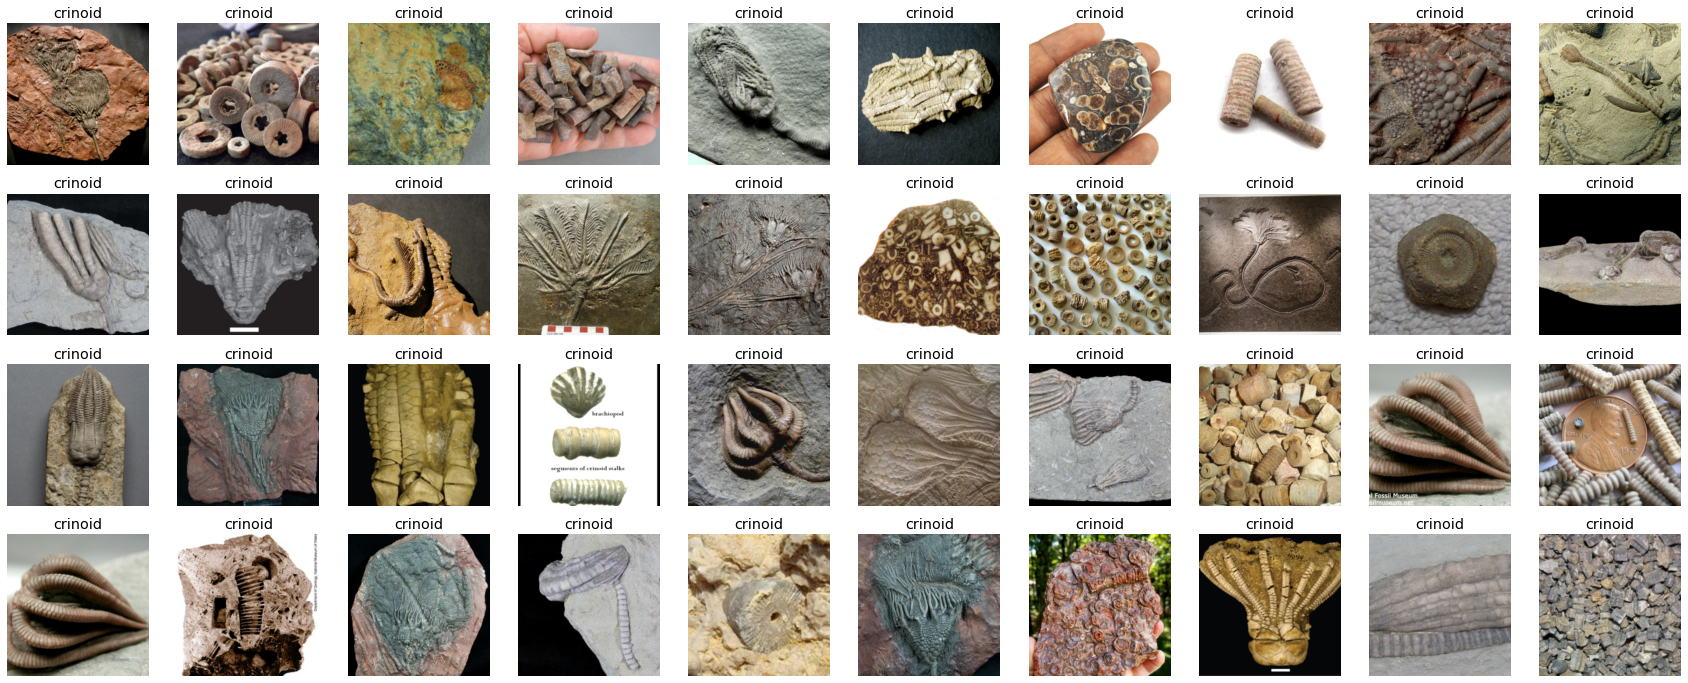

In [11]:
dls.show_batch(max_n=40, nrows=4)

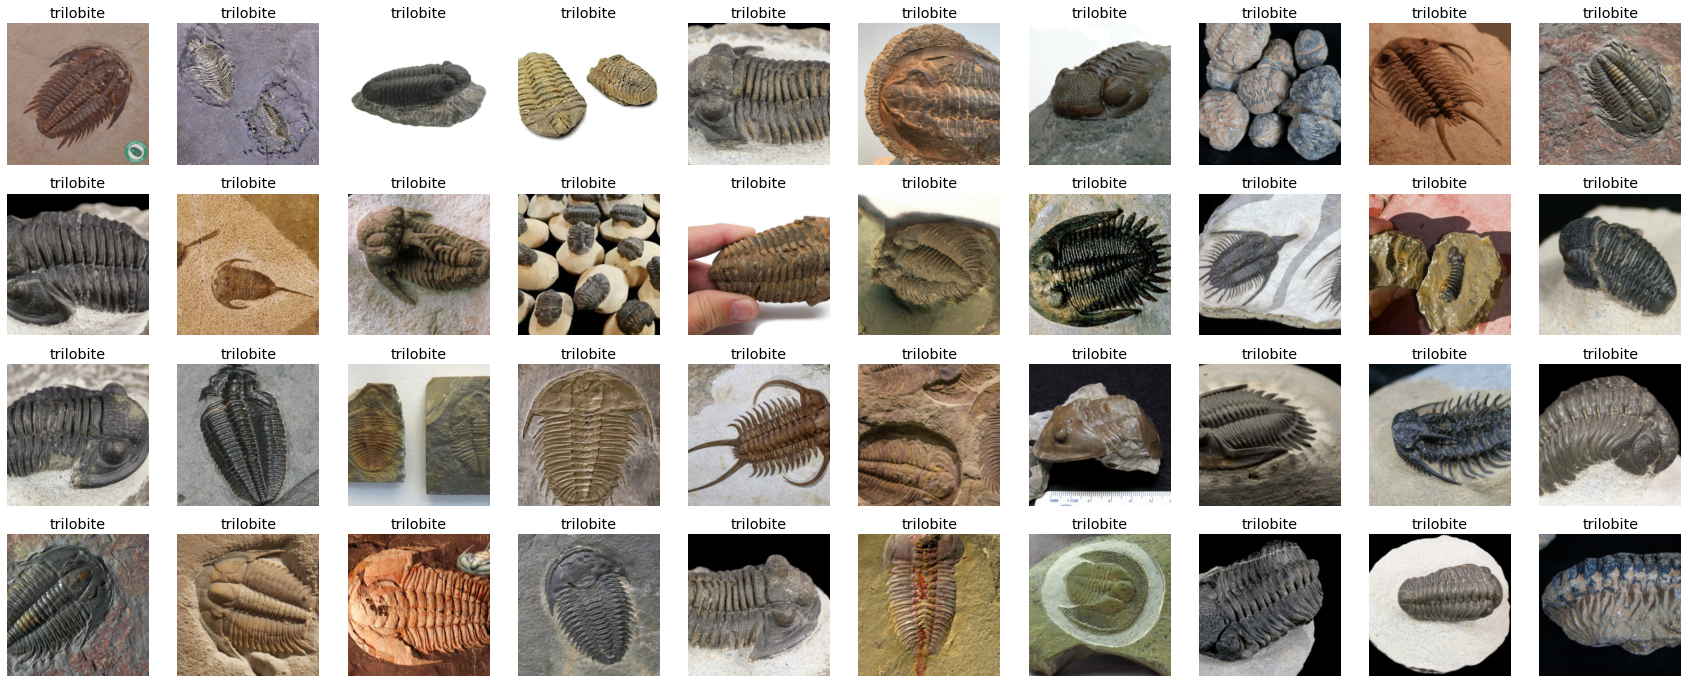

In [11]:
dls = ImageDataLoaders.from_folder(path/'trilobite', valid_pct=0.2, item_tfms=Resize(256))
dls.show_batch(max_n=40, nrows=4)

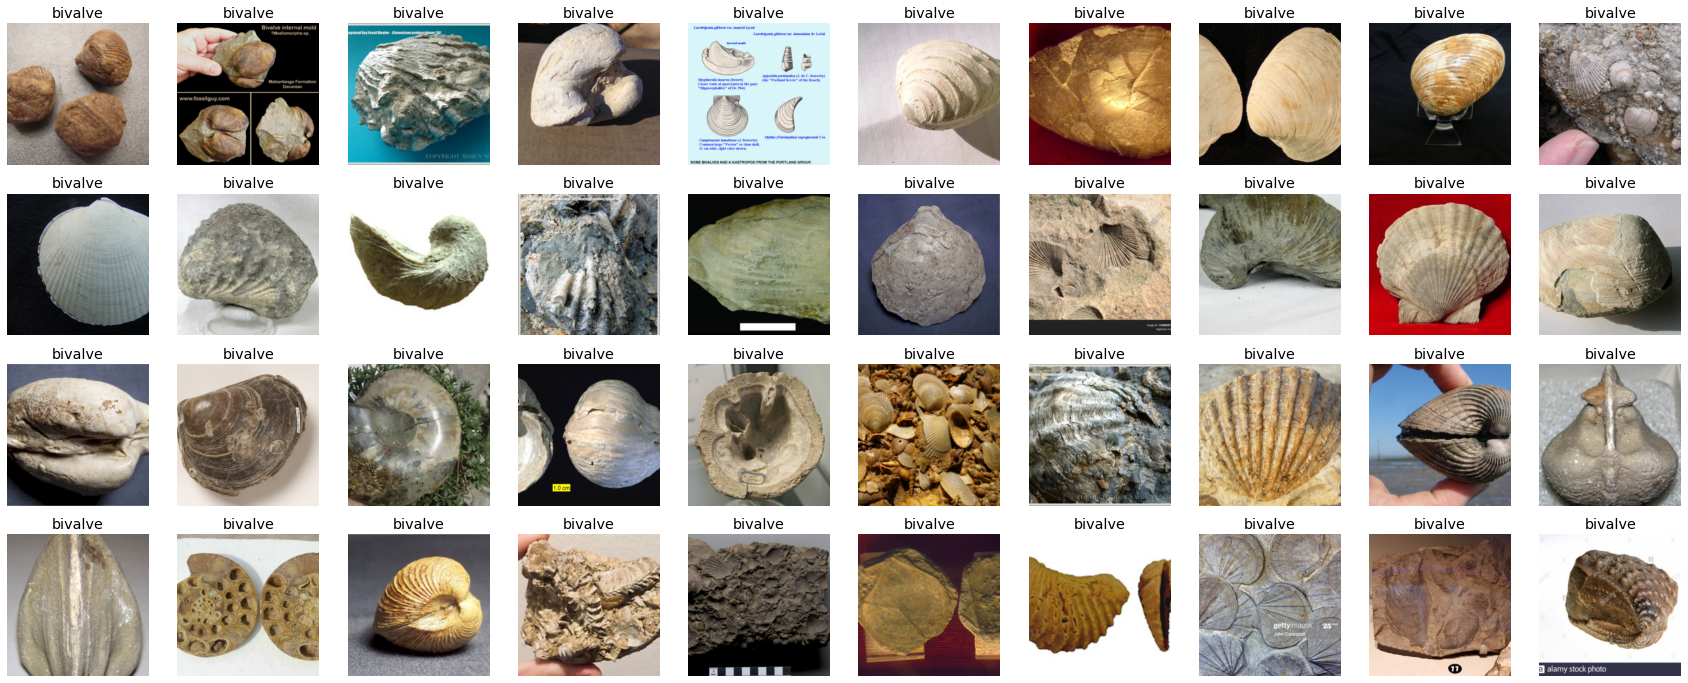

In [12]:
dls = ImageDataLoaders.from_folder(path/'bivalve', valid_pct=0.2, item_tfms=Resize(256))
dls.show_batch(max_n=40, nrows=4)

We are now ready to create a DataBlock. The DataBlock will contain our images and labels; it will need to know how to 'find' the items, how to separate them into a training set and a validation set, where to get the dependent variable from (the label, e.g. the directory they are in), and last how to transform the image so that we can run CUDA on it.

In [20]:
critters = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(256, min_scale=0.3))

The data block has not yet seen our data, so lets show it the data.

In [21]:
dls = critters.dataloaders(path, bs=64)

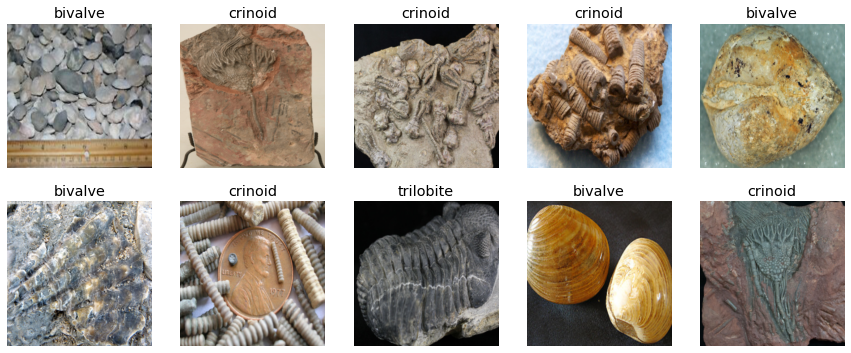

In [15]:
dls.valid.show_batch(max_n=10, nrows=2)

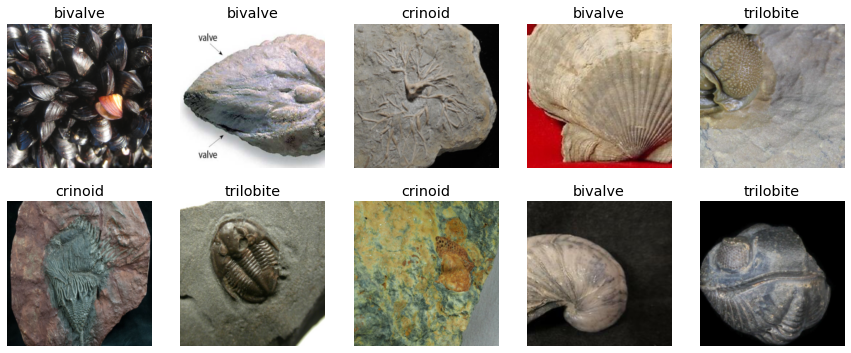

In [16]:
dls.train.show_batch(max_n=10, nrows=2)

In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

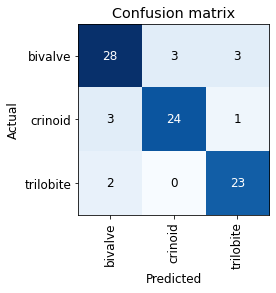

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

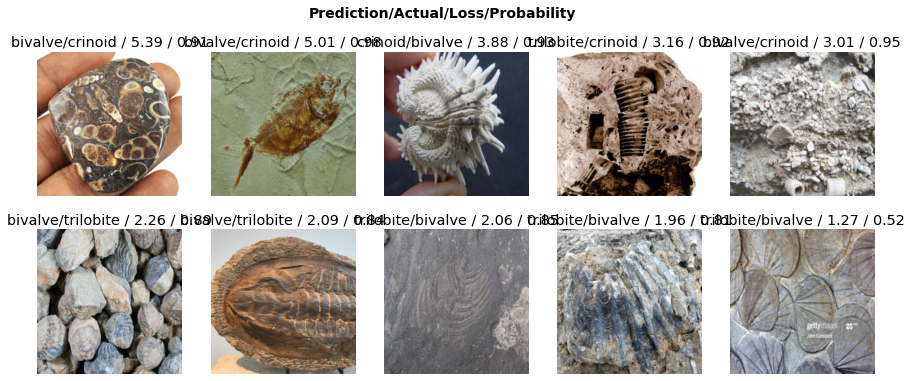

In [16]:
interp.plot_top_losses(10, nrows=2)

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [25]:
learn.export()
#path.ls(file_exts='.pkl')

In [26]:
p = Path()
p.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

I had some cleanup issues when using the `ImageClassifierCleaner()` class. After using the widget and then invoking the `for` loops to unlink and move the images, it threw an exception because filenames already existed. It appears it had problems counting the images/moving the files due to name collisions. It also wasn't clear what to do after cleaning the dataset - simply running `learn.fine_tune(1)` did not work since the dataset had changed, so I reinitialized the datablock and retrained the model. This improved performance from an error rate of about 17% to about 14%.